In [1]:
import sys
sys.path.insert(0, "../code/data")
sys.path.insert(0, "../code/utils")

import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import cm
from tqdm.notebook import trange, tqdm
from functions_markov import fillmarkov, compute_P_0, normalize_matrix, generate_chain, compute_P0_inner_loop
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
import multiprocessing
import concurrent
import time
import random


In [10]:
def plot_P0(P0stat, T, ax, scale_text=15, color=None, param_name="a", do_r2_fit=True):
    xv=np.concatenate(([1], np.arange(2, P0stat.shape[0], 2)))
    x_100=np.arange(10, P0stat.shape[0], 2)
    # plot only initial value and even values to remove oscillations
    y_100=P0stat[x_100]
    
    def exp_f(x, a, b):
        return a * np.power(x, b)
    popt, pcov = curve_fit(exp_f, x_100, y_100)
    y_pred=exp_f(x_100, *popt)
    
    #model_linreg = LinearRegression()
    #model_linreg.fit(x_100, y_100)
    #y_pred=model_linreg.predict(x_100)
    #coeff=model_linreg.coef_[0][0]
    if do_r2_fit:
        r2_score=metrics.r2_score(y_100, y_pred)
  
    if np.any(color):
        ax.plot(xv, P0stat[xv], label=f"{param_name}{T}", color=color, linewidth=2)
    else:
        ax.plot(xv, P0stat[xv], label=f"{param_name}{T}", linewidth=2)
    if isinstance(T, float): T = np.round(T, 3)
    if isinstance(T, int): T = float(T)
    
    if do_r2_fit:
        if isinstance(r2_score, int): r2_score = float(r2_score)
        label1="T={0:.3}, r2={1:.3}".format(T, r2_score)
        ax.plot(x_100, y_pred, 'k--', label=label1, linewidth=1)
        
    ax.legend(fontsize=scale_text)
    ax.tick_params(axis='both', which='major',labelsize=scale_text)
    try:
        ax.set_yscale('log')
        ax.set_xscale('log')
    except:
        print("not log scaled")
    
    ax.set_xlabel('∆t', fontsize=scale_text)
    ax.set_ylabel('P0(∆t)', fontsize=scale_text)
    ax.set_xlim(1, 1e4)
    ax.set_xticks([1, 10, 1e2, 1e3, 1e4])
    return popt[1]

#Relationship between T and slope
def plot_temp_vs_slope(t_range, coeffs, plot_title):
    f,a = plt.subplots(1,1)
    a.plot(t_range, coeffs, marker='o')
    a.set_xlabel("Temperature")
    a.set_ylabel("Linear slope coeff")
    a.set_title("Relationship between T and slope", fontsize=20)
    f.savefig(plot_title, dpi=300)
    plt.show()
    
def compute_P0_multiprocess(executor, maxh, chain, tree_l):
    print("Computing P_0...")
    P0=np.zeros(maxh)
    P0stat=np.zeros(maxh)
    
    i_set = set(chain)
    futures = [executor.submit(compute_P0_inner_loop, i, P0, chain, tree_l, maxh)
               for i in i_set]
    concurrent.futures.wait(futures)
    print(f"#futures: {len(futures)}")
    for future in futures:
        res = future.result()
        P0stat = P0stat + res
        
    P0stat[0]=1
    P0stat[1]=1
    return P0stat

def shuffle_blocks_v2(chain, b_len):
    shuff_chain = chain.copy() #bc we modifiy in-place afterward
    blocks = [shuff_chain[i:i+b_len] for i in range(0,len(shuff_chain),b_len)]
    np.random.shuffle(blocks)
    shuff_chain[:] = [b for bs in blocks for b in bs]
    return shuff_chain

# shuffled data
def plot_autocorr(chain, tree_l, title='', blocklengths= [1, 10, 100, 400, 800], cmap=None):
    P0_result_list=[]
    nbl=len(blocklengths)
    f3, a3 = plt.subplots(1,1)
    f3.set_figheight(8)
    f3.set_figwidth(12)

    #No shuffle baseline
    if len(chain) >= 1e9:
        P0stat = compute_P0_multiprocess(executor4, maxh, chain, tree_l)
    else:
        _, P0stat = compute_P_0(maxh, tree_l, chain, verbose=1)
    P0_result_list.append(P0stat)
    
    color_i=None
    if cmap:
        color_i=cmap(1.0)
    plot_P0(P0stat, 0.0, a3, scale_text=15, param_name="baseline=", do_r2_fit=False, color=color_i)
    #f3.savefig(f"../plots/temp_plot_{title}_no_shuffle_depth_{tree_levels}_clen_{chain_length}.pdf", dpi=300)

    for bl in range(0, nbl):
        blength=blocklengths[bl]
        print(f'Block length: {blength}')
        shuffled_chain=shuffle_blocks_v2(chain, blength)

        if len(shuffled_chain) >= 1e9:
            P0stat = compute_P0_multiprocess(executor4, maxh, shuffled_chain, tree_l)
        else:
            _, P0stat = compute_P_0(maxh, tree_l, shuffled_chain, verbose=1) 
            
        P0_result_list.append(P0stat)
        color_i=cmap((bl+1)/(nbl+2))
        plot_P0(P0stat, blength, a3, scale_text=15, param_name="b_len=", do_r2_fit=False, color=color_i)
        
    a3.set_title(f'Auto-correlation for {title} sequence depth {int(np.log2(tree_l))}', fontsize=20)
    f3.savefig(f"../plots/plot_{title}_shuffled_blength_{blength}.pdf", dpi=300)    
    return a3, f3, P0_result_list

def set_split_chain(nb_classes, s_len=400, stoch_s_len=False, tot_nb_blocks=10000):
    classes = np.random.choice(np.arange(0, nb_classes-1, step=2), size=tot_nb_blocks)
    classes[0] = 0

    if not stoch_s_len:
        split_chain = [el for class1 in classes for el in np.random.randint(low=class1, high=class1+2, size=s_len)]
    else:
        sizes = np.random.randint(low=max(int(s_len*0.75), 50), high=min(int(s_len*1.25), 2000), size=tot_nb_blocks)
        split_chain = [el for class1, size1 in zip(classes, sizes) for el in np.random.randint(low=class1, high=class1+2, size=size1)]
    
    return np.array(split_chain)

# Plot Auto-corr w different T

In [3]:
#DEF VARS
dia=0
tree_levels=[5,6,7,8]
maxh=10000 # 10000
chain_length = 1000000 # 1000000
nb_parallel_executors = 4
executor4 = concurrent.futures.ProcessPoolExecutor(nb_parallel_executors)

cmap_blue = plt.get_cmap('Blues') # for UM
cmap_red = plt.get_cmap('Reds') # for split
cmap_purple = plt.get_cmap('Purples') # for split stoch

purple = cmap_purple(0.7) # for split stoch
red = cmap_red(0.7) # for split

t_ranges = [[0.325, 0.35, 0.4, 0.45],
            [0.35, 0.375, 0.4, 0.45, 0.5],
            [0.375, 0.4, 0.45, 0.5, 0.55],
            [0.4, 0.425, 0.45, 0.5, 0.55, 0.6]]

# level 3 for MNIST
t_ranges = [[0.225, 0.25, 0.275, 0.3, 0.35]]
tree_levels=[3]

In [ ]:
for j, tree_level in enumerate(tree_levels):
    print('TREE LEVEL: ', tree_level)
    f2, a2 = plt.subplots(1,1)
    f2.set_figheight(8)
    f2.set_figwidth(12)
    tree_l=2**tree_level # number of leaves
    markovm=np.zeros((tree_l,tree_l))
    t_effective, coeffs=[], []
    
    t_range = t_ranges[j]
    t_range = [np.around(t, 3) for t in t_range]
    viridis = cm.get_cmap('plasma', len(t_range))

    for i, T in tqdm(enumerate(t_range), total=len(t_range)):
        markovm=fillmarkov(markovm,0,0,tree_l,tree_level)
        markovme=np.exp(-markovm/T)
        markovme = normalize_matrix(dia, tree_l, markovme)
        
        max_chains = []
        for repeat in range(5): #generate chains with 5 diff seeds to be sure max is reached each time
            print(repeat, end=' ')
            chain = generate_chain(markovme, chain_length, verbose=0)
            max_chains.append(np.max(chain))
            
        print(f"Temp {T}, chain_length: {len(chain)}, Chain_maxval: {np.min(max_chains)}")
        if np.min(max_chains) < tree_l-1: continue

        start_time = time.time()
        if len(chain) >= 1e7:
            print(f"Parallel w {nb_parallel_executors} executors")
            P0stat = compute_P0_multiprocess(executor4, maxh, chain, tree_l)
        else:
            _, P0stat = compute_P_0(maxh, tree_l, chain, verbose=0)
        end_time = time.time()
        print(f"P_0 computed in {(end_time-start_time)/60:.3}min")

        coeff=plot_P0(P0stat, T, a2, scale_text=15, color=viridis.colors[i], param_name="T")
        coeffs.append(coeff)
        t_effective.append(T)
        f2.savefig(f"../plots/temp_plot_iter_{i}_clen_{len(chain)}.pdf")
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    a2.set_title(f"Auto-correlation for depth {tree_level}", fontsize=20)
    f2.savefig(f"../plots/plots_P0_{current_time}_depth_{tree_level}_clen_{chain_length}.pdf", dpi=300)
    plt.show()
    plot_title = f"../plots/plot_TvsSlope_{current_time}_depth_{tree_level}_clen_{chain_length}.pdf"
    plot_temp_vs_slope(t_effective, coeffs, plot_title)


# Shuffled data

In [8]:
maxh=10000 # 10000
chain_length = 1000000 # 10000000
dia=0

tree_levels_list=[7,8]
T_list=[0.475,0.55]
blocklengths= [1, 10, 100, 400, 800]


TREEE_L 128
Generating Markov chain...
Plot UM Autocorr
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 1
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 10
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 100
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 400
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 800
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Plot Split Autocorr
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 1
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 10
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 100
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 400
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 800
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Plot Stochastic Split Autocorr
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 1
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 10
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 100
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 400
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
Block length: 800
Computing P_0...


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed
TREEE_L 256
Generating Markov chain...
Plot UM Autocorr
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 1
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 10
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 100
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 400
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 800
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Plot Split Autocorr
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 1
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 10
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 100
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 400
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 800
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Plot Stochastic Split Autocorr
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 1
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 10
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 100
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 400
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed
Block length: 800
Computing P_0...


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed


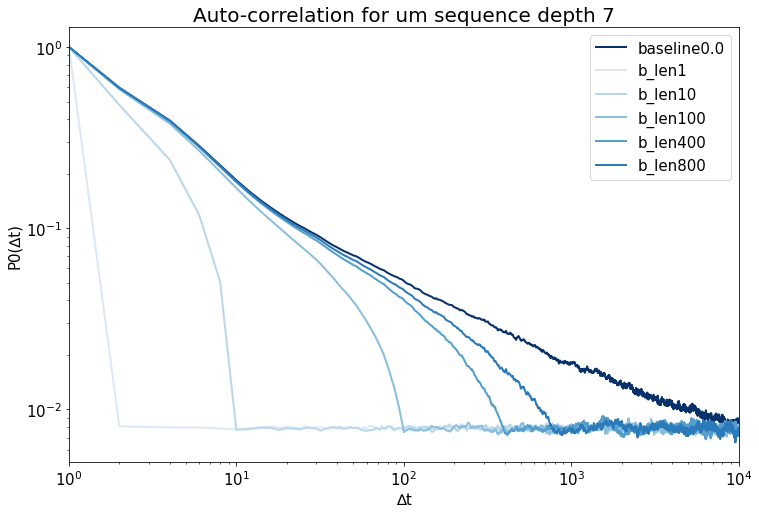

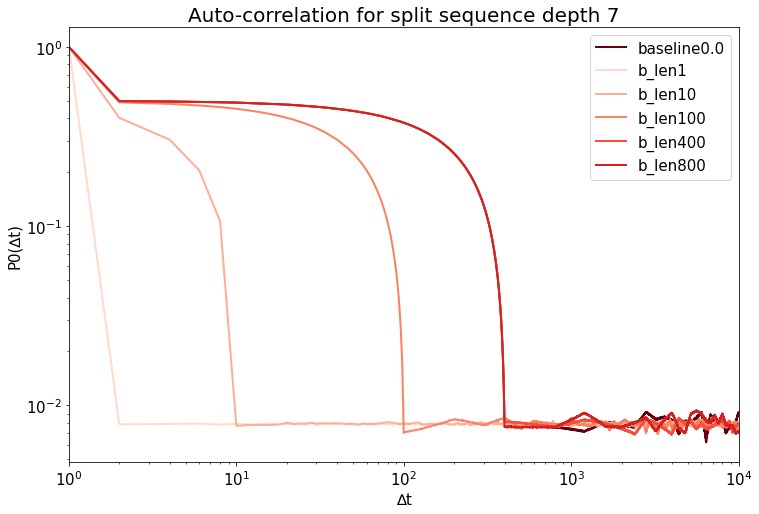

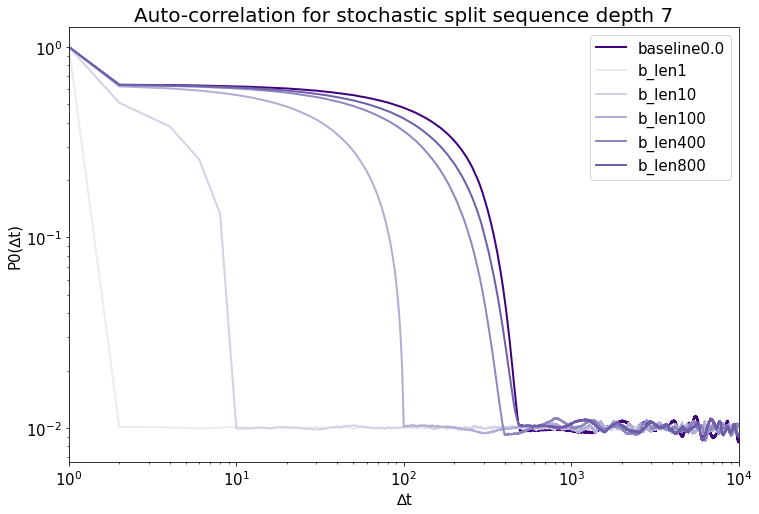

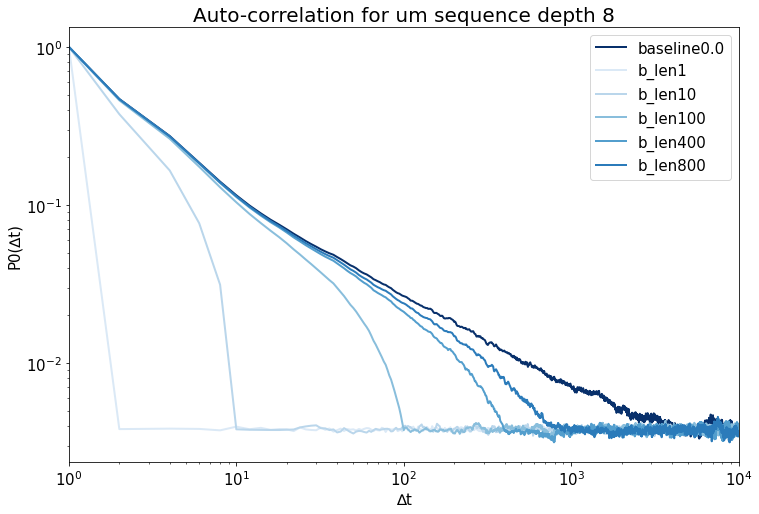

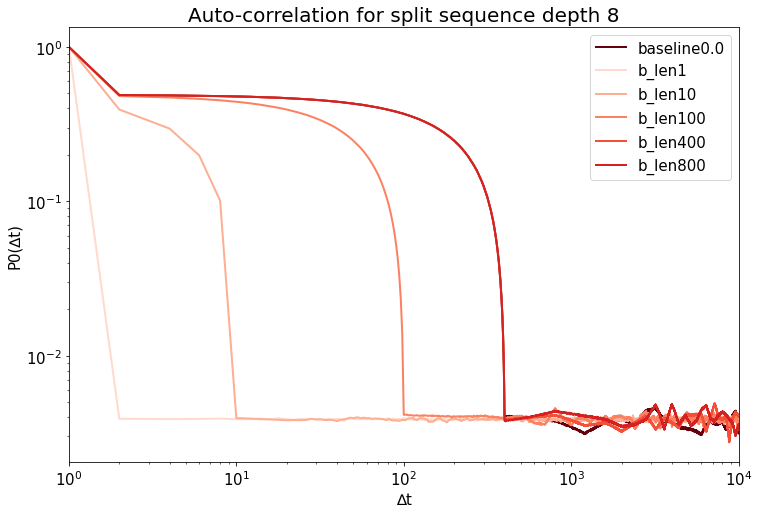

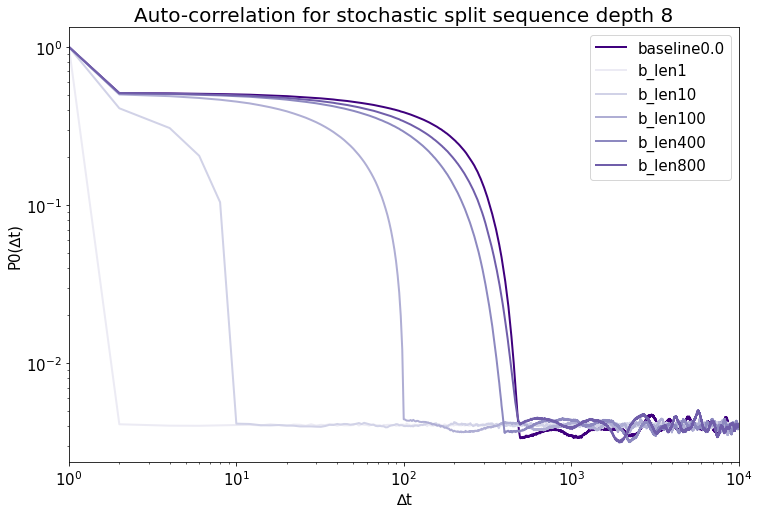

In [9]:
for tree_levels, T in zip(tree_levels_list, T_list):
    tree_l=2**tree_levels # number of leaves
    print("TREEE_L", tree_l)
    markovm=np.zeros((tree_l,tree_l))
    markovm=fillmarkov(markovm,0,0,tree_l,tree_levels)
    markovme=np.exp(-markovm/T)
    markovme = normalize_matrix(dia, tree_l, markovme)
    chain = generate_chain(markovme, chain_length, verbose=1)

    print('Plot UM Autocorr')
    a5,f5,P0_result_list_um =plot_autocorr(chain, tree_l, title='um', 
                                           blocklengths= blocklengths,
                                           cmap=cmap_blue)

    print('Plot Split Autocorr')
    split_chain = set_split_chain(nb_classes=tree_l, s_len=400, stoch_s_len=False, 
                                  tot_nb_blocks=10000)
    a6, f6, P0_result_list_split =plot_autocorr(split_chain, tree_l, title='split', 
                                                blocklengths= blocklengths,
                                                cmap=cmap_red)

    print('Plot Stochastic Split Autocorr')
    split_chain_stoch = set_split_chain(nb_classes=tree_l, s_len=400, stoch_s_len=True, 
                                        tot_nb_blocks=10000)
    a7, f7, P0_result_list_split_stoch =plot_autocorr(split_chain_stoch, tree_l, 
                                                      title='stochastic split', 
                                                      blocklengths= blocklengths,
                                                      cmap=cmap_purple)


In [ ]:
# Plot UM Autocorr
a5,f5,P0_result_list_um =plot_autocorr(chain, tree_l, title='um', 
                                       blocklengths= [1, 10, 100, 400, 800],
                                       cmap=cmap_blue)

## Split chain autocorr

In [ ]:
split_chain = set_split_chain(nb_classes=32, s_len=400, stoch_s_len=False, tot_nb_blocks=10000)
a6, f6, P0_result_list_split =plot_autocorr(split_chain, tree_l, title='split', 
                                            blocklengths= [1, 10, 100, 400, 800],
                                            cmap=cmap_red)

Computing P_0...
#futures: 32
Block length: 1
Computing P_0...
#futures: 32
Block length: 10
Computing P_0...
#futures: 32
Block length: 100
Computing P_0...
#futures: 32
Block length: 400
Computing P_0...
#futures: 32
Block length: 800
Computing P_0...
#futures: 32


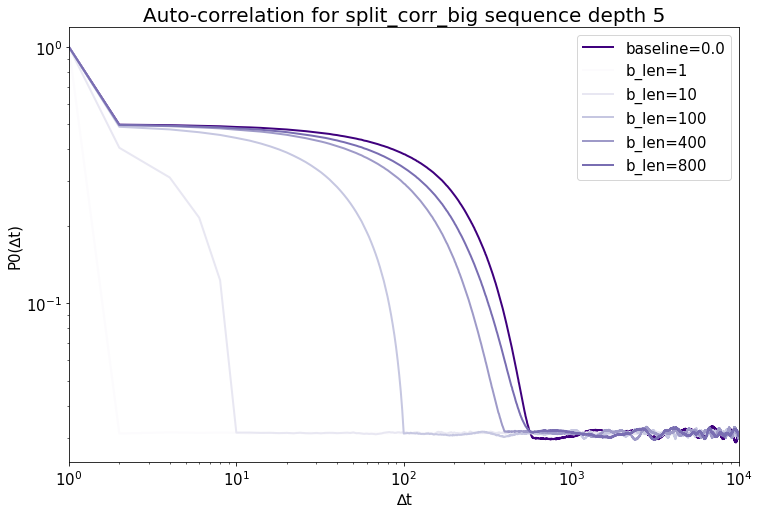

In [12]:
# W stoch
split_chain_stoch = set_split_chain(nb_classes=32, s_len=400, stoch_s_len=True, tot_nb_blocks=10000)
a7, f7, P0_result_list_split_stoch =plot_autocorr(split_chain_stoch, tree_l, 
                                                  title='split_corr_big', 
                                                  blocklengths= [1, 10, 100, 400, 800],
                                                  cmap=cmap_purple)

### Plots w/o recompute

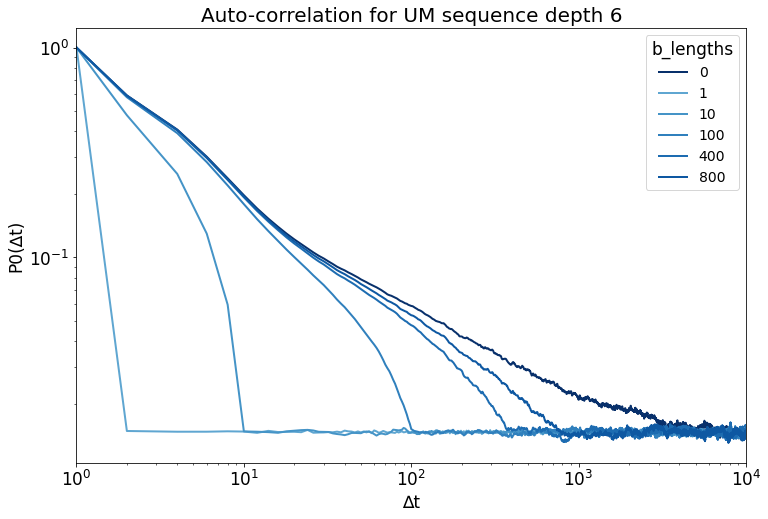

In [28]:
def plot_autocorr_wo_recompute(P0_result_list, cmap=cmap_blue, title='UM sequence depth 5', 
                               title_save='um_d5', blocklengths= [0, 1, 10, 100, 400, 800]):
    f10,a10= plt.subplots(1,1)
    f10.set_figheight(8)
    f10.set_figwidth(12)
    a10.set_title(f'Auto-correlation for {title}', fontsize=20)
    nb_blen = len(blocklengths)

    for i, (p0, blength) in enumerate(zip(P0_result_list, blocklengths)):
        if i==0:
            color=cmap(1.0)
        else:
            color=cmap((i+6)/(nb_blen+7))
        plot_P0(p0, blength, a10, scale_text=17, param_name="", 
                do_r2_fit=False, color=color)

    plt.legend(title='b_lengths', fontsize=14, title_fontsize=17)
    f10.savefig(f'Autocorr_{title_save}_shuff.pdf', dpi=300)
    plt.show()

plot_autocorr_wo_recompute(P0_result_list_um, cmap=cmap_blue, title='UM sequence depth 6', 
                               title_save='um_d6', blocklengths= [0, 1, 10, 100, 400, 800])

[array([1., 1., 0., ..., 0., 0., 0.]), array([1., 1., 0., ..., 0., 0., 0.]), array([1., 1., 0., ..., 0., 0., 0.]), array([1., 1., 0., ..., 0., 0., 0.]), array([1., 1., 0., ..., 0., 0., 0.]), array([1., 1., 0., ..., 0., 0., 0.])]


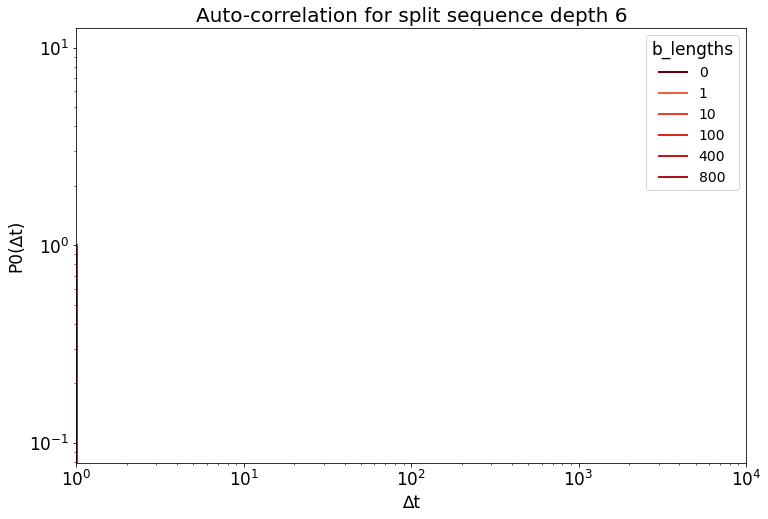

In [30]:
print(P0_result_list_split)
plot_autocorr_wo_recompute(P0_result_list_split, cmap=cmap_red, title='split sequence depth 6', 
                               title_save='split_d6', blocklengths= [0, 1, 10, 100, 400, 800])

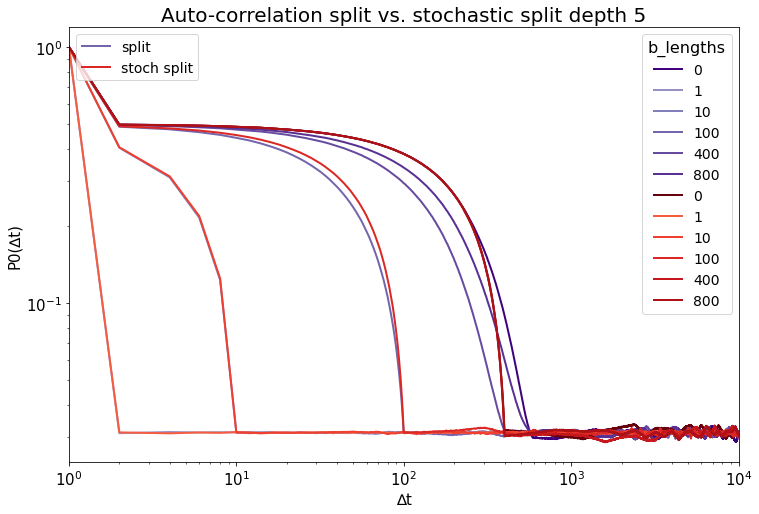

In [66]:
f10,a10= plt.subplots(1,1)
f10.set_figheight(8)
f10.set_figwidth(12)
a10.set_title('Auto-correlation split vs. stochastic split depth 5', fontsize=20)
blocklengths= [0, 1, 10, 100, 400, 800]
nb_blen = len(blocklengths)

for i, (p0, blength) in enumerate(zip(P0_result_list_split_stoch, blocklengths)):
    if i==0:
        color=cmap_purple(1.0)
    else:
        color=cmap_purple((i+6)/(nb_blen+7))
    plot_P0(p0, blength, a10, scale_text=15, param_name="", 
            do_r2_fit=False, color=color)

for i, (p0, blength) in enumerate(zip(P0_result_list_split, blocklengths)):
    if i==0:
        color=cmap_red(1.0)
    else:
        color=cmap_red((i+6)/(nb_blen+7))
    plot_P0(p0, blength, a10, scale_text=15, param_name="", 
            do_r2_fit=False, color=color)

handles, labels = a10.get_legend_handles_labels()
legend1 = plt.legend([handles[3], handles[9]], ["split", "stoch split"], loc=2, fontsize=14, title_fontsize=16)
plt.gca().add_artist(legend1)
plt.legend(title='b_lengths', fontsize=14, title_fontsize=16)

f10.savefig('Autocorr_split_vs_stochsplit_d5_shuff.pdf', dpi=300)
plt.show()

# Generate sequ to save

In [88]:
#DEF VARS
dia=0
chain_length = 1000000 # 10000000
# peut etre mettre 0.43 pour d=7

T_fixed=[0.4,0.45,0.475,0.55, 0.575] #,0.575,0.6]
#T_fixed_new_harder=[0.35,0.38,0.4,0.5] # new values chosen make it harder to nav tree, 
                                    #e barrier is higher bc temp is lower
tree_levels_list=[5,6,7,8]

##
T_fixed=[0.25]
tree_levels_list=[3]



In [ ]:
for seed in np.arange(0, 50):
    print('seed: ', seed, end=' ')
    for tree_levels, T in zip(tree_levels_list, T_fixed): # zip selected temperatures
        tree_l=2**tree_levels
        random.seed(int(seed))
        markovm=np.zeros((tree_l,tree_l))

        markovm=fillmarkov(markovm,0,0,tree_l,tree_levels)
        markovme=np.exp(-markovm/T)
        markovme = normalize_matrix(dia, tree_l, markovme)
        # generate the markov chain
        chain = generate_chain(markovme, chain_length, verbose=1)
        if np.max(chain) < tree_l-1:
            print(f"ERR AT: seed{seed} ,tree_levels{tree_levels}, T{T}")

        np.save(f"../data/saved_chains/tree_levels{tree_levels:02d}_clen{chain_length:.1e}_seed{seed:}", np.array(chain))

In [ ]:
#Load chain from file test
from os import listdir
from os.path import isfile, join
mypath = "../data/saved_chains/"
onlyfiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = sorted(onlyfiles, reverse=False)
for file in onlyfiles:
    if "DS_Store" not in file:
        if ('levels05' in file or 'levels06' in file or 'levels07' in file) and ('seed0' in file or 'seed1.' in file or 'seed2.' in file or 'seed3.' in file or 'seed4.' in file):
            print(file) 
            f,a=plt.subplots(1,2)
            
            chain = np.load(file).tolist()
            x_values = np.arange(0,1e5,1000)
            patterns_discovered = [len(set(chain[:int(i)])) for i in x_values]
            pct_patterns_discovered = np.array(patterns_discovered) / len(set(chain))
            a[0].plot(x_values, pct_patterns_discovered)
            a[0].set_title('cumulative')
            a[0].set_ylim(0,1.1)
            
            #moving avg
            patterns_discovered = [len(set(chain[int(i):int(i)+10000])) for i in x_values]
            pct_patterns_discovered = np.array(patterns_discovered) / len(set(chain))
            mean_val = np.mean(pct_patterns_discovered)
            var_val = np.var(pct_patterns_discovered)
            a[1].plot(x_values, pct_patterns_discovered)
            a[1].plot(x_values, np.ones(len(x_values))*mean_val, color='k', linestyle='--', label=f'mean: {mean_val:.2}±{var_val:.2}')
            a[1].set_title('moving avg')
            a[1].set_ylim(0,1.1)
            f.set_size_inches(15,5)
            plt.legend()
            plt.show()
        

In [ ]:
path_chain='/Users/jeromjeromee/Documents/EPFL/PDM/repo/data/saved_chains/tree_levels05_clen1.0e+06_seed1.npy'
chain = np.load(path_chain).tolist()

In [ ]:
[print(i, end=' ') for i in chain[:1000]]